In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
df = pd.read_csv("https://raw.githubusercontent.com/mpipatta/mpipatta.github.io/master/testdata/load_temp2016.csv")

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 5 columns):
month    8784 non-null int64
day      8784 non-null int64
hh       8784 non-null int64
load     8784 non-null float64
Temp     8784 non-null int64
dtypes: float64(1), int64(4)
memory usage: 343.2 KB


,month,day,hh,load,Temp
0,1,1,0,4.3000,74
1,1,1,1,4.1200,0
2,1,1,2,4.0625,0
3,1,1,3,4.4375,0
4,1,1,4,3.8750,0


In [6]:
df['Year']='2016'

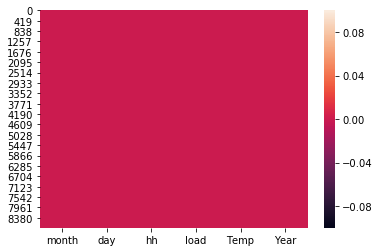

In [7]:
sns.heatmap(df.isnull())

In [8]:
def toDateTime(columns):
    month=columns['month']
    day=columns['day']
    hour=columns['hh']
    year=columns['Year']

    return pd.to_datetime(str(year)+"-"+str(month)+"-"+str(day)+" "+str(hour)+":00")

In [9]:
df['DateTime']=df.apply(toDateTime,axis=1)
df.drop(['month','day','Year','hh'],axis=1,inplace=True)

In [10]:
df.dtypes

load               float64
Temp                 int64
DateTime    datetime64[ns]
dtype: object

In [11]:
df.isnull().sum()

load        0
Temp        0
DateTime    0
dtype: int64

In [12]:
df.set_index('DateTime',inplace=True)

In [13]:
df.describe()

,load,Temp
count,8784.00000,8784.000000
mean,18.27804,83.663365
std,18.76574,12.129081
min,0.00000,0.000000
25%,6.00000,82.000000
50%,8.81250,85.000000
75%,27.50000,89.000000
max,104.25000,100.000000


## Removing 0 values

In [14]:
df['Temp']=df['Temp'].apply(lambda x:np.nan if x==0 else x)
df['load']=df['load'].apply(lambda x:np.nan if x==0 else x)

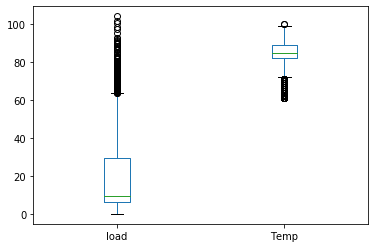

In [15]:
df[['load','Temp']].plot(kind='box')

In [16]:
df['Temp']=df['Temp'].apply(lambda x:(x-32)*5/9)

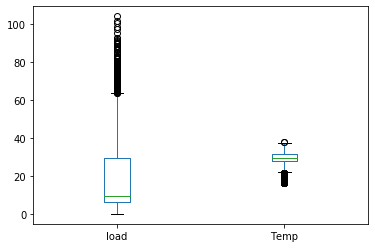

In [17]:
df[['load','Temp']].plot(kind='box')

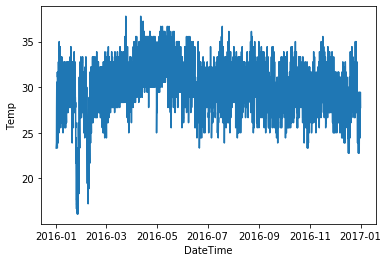

In [18]:
sns.lineplot(df.index,df['Temp'])

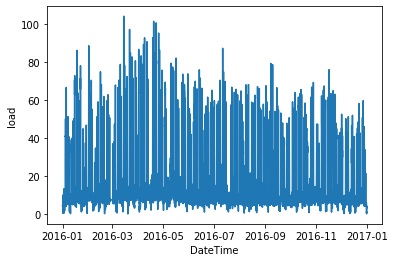

In [19]:
sns.lineplot(df.index,df['load'])

In [20]:
df.interpolate(method='linear', limit_direction='forward', axis=0,inplace=True)

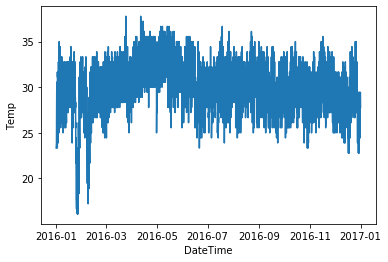

In [21]:
sns.lineplot(df.index,df['Temp'])

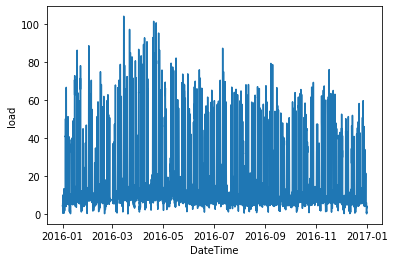

In [22]:
sns.lineplot(df.index,df['load'])

In [23]:
dayofweek=df.index.dayofweek

In [24]:
df['dow']=dayofweek

In [25]:
df['dow'].value_counts()

5    1272
4    1272
6    1248
3    1248
2    1248
1    1248
0    1248
Name: dow, dtype: int64

In [28]:
df.head()

,load,Temp,dow,daytime
DateTime,,,,
2016-01-01 00:00:00,4.3000,23.333333,4,0
2016-01-01 01:00:00,4.1200,23.402778,4,0
2016-01-01 02:00:00,4.0625,23.472222,4,0
2016-01-01 03:00:00,4.4375,23.541667,4,0
2016-01-01 04:00:00,3.8750,23.611111,4,0


In [30]:
df.reset_index(inplace=True)
df['daytime']=df['DateTime'].apply(lambda x : 1 if (x.hour>=8 and x.hour<=18 and x.dayofweek<5) else 0)
df.set_index('DateTime',inplace=True)

In [31]:
df

,load,Temp,dow,daytime
DateTime,,,,
2016-01-01 00:00:00,4.300000,23.333333,4,0
2016-01-01 01:00:00,4.120000,23.402778,4,0
2016-01-01 02:00:00,4.062500,23.472222,4,0
2016-01-01 03:00:00,4.437500,23.541667,4,0
2016-01-01 04:00:00,3.875000,23.611111,4,0
...,...,...,...,...
2016-12-31 19:00:00,3.491379,28.888889,5,0
2016-12-31 20:00:00,3.250000,28.333333,5,0
2016-12-31 21:00:00,3.500000,27.777778,5,0


In [32]:
df[(df['daytime']==0)&(df['load']>=40)]

,load,Temp,dow,daytime
DateTime,,,,
2016-04-07 07:00:00,42.7500,29.444444,3,0
2016-11-23 06:00:00,41.7500,28.333333,2,0
2016-11-23 07:00:00,44.4375,27.777778,2,0


In [33]:
len(df[df['Temp']>30])

3385

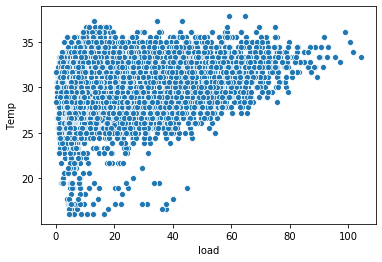

In [34]:
sns.scatterplot(x='load',y='Temp',data=df)

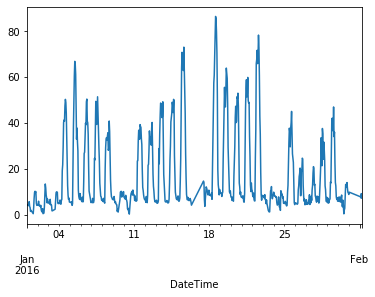

In [72]:
df.iloc[0:750]['load'].plot()

In [77]:
df_work=df[df['dow']<5]

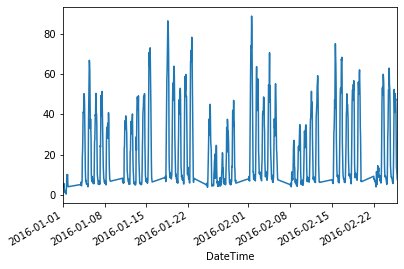

In [82]:
df_work.iloc[:24*40]['load'].plot()

<Figure size 432x288 with 0 Axes>

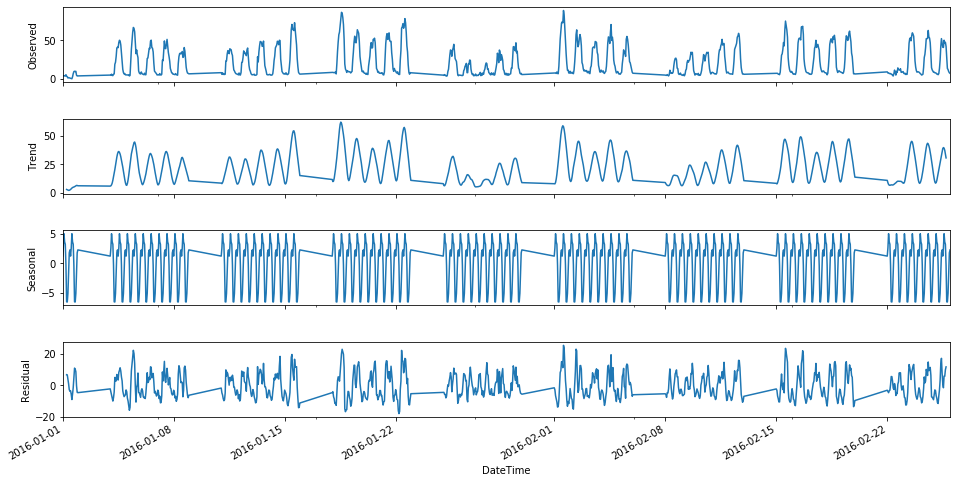

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_work.iloc[:24*40]['load'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [87]:
from statsmodels.tsa.stattools import adfuller

In [88]:
result = adfuller(df_work.iloc[:24*40]['load'])

In [89]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.3978521834465263
p-value : 0.011032308800221494
#Lags Used : 22
Number of Observations Used : 937
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [90]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

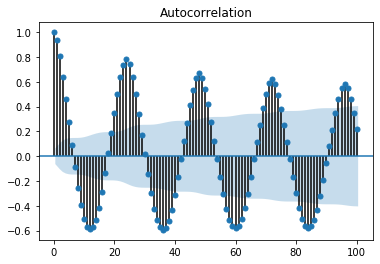

In [93]:
plot_acf(df_work.iloc[:24*40]['load'],lags=100);

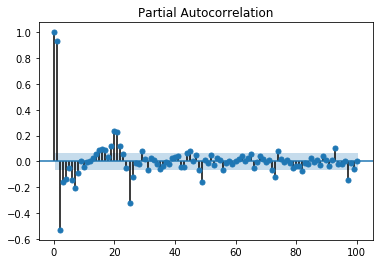

In [94]:
plot_pacf(df_work.iloc[:24*40]['load'],lags=100);

In [97]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [118]:
df_work

,load,Temp,dow,daytime,forecast
DateTime,,,,,
2016-01-01 00:00:00,4.3000,23.333333,4,0,NaN
2016-01-01 01:00:00,4.1200,23.402778,4,0,NaN
2016-01-01 02:00:00,4.0625,23.472222,4,0,NaN
2016-01-01 03:00:00,4.4375,23.541667,4,0,NaN
2016-01-01 04:00:00,3.8750,23.611111,4,0,NaN
...,...,...,...,...,...
2016-02-25 19:00:00,13.7500,31.666667,3,0,53.289474
2016-02-25 20:00:00,12.2500,31.666667,3,0,53.289474
2016-02-25 21:00:00,9.6250,31.111111,3,0,53.289474


In [120]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(df_work['load'],order=(1,1,0))
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                   load   No. Observations:                  960
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3097.702
Date:                Sun, 29 Mar 2020   AIC                           6199.404
Time:                        13:10:19   BIC                           6209.136
Sample:                             0   HQIC                          6203.110
                                - 960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4770      0.022     21.515      0.000       0.434       0.520
sigma2        37.4171      1.140     32.827      0.000      35.183      39.651
Ljung-Box (Q):                      496.37   Jarque-

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


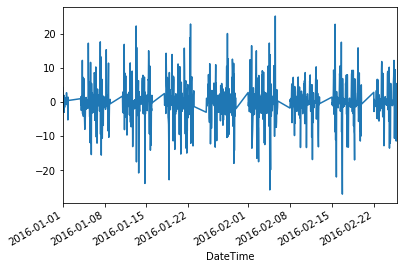

In [121]:
results.resid.plot()

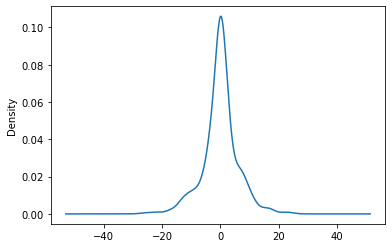

In [122]:
results.resid.plot(kind='kde')

In [124]:
#df_work=df_work.iloc[:24*40]

###### df_work

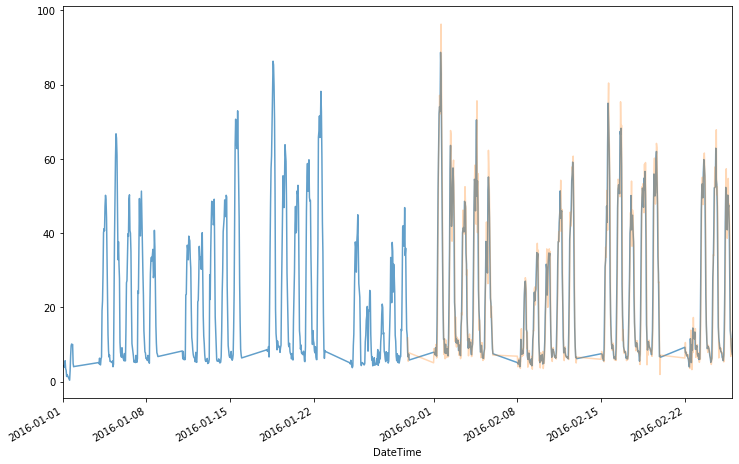

In [136]:
df_work['forecast'] = results.predict(start = 500, end= 959)  
df_work['load'].plot(figsize=(12,8),alpha=0.7)
df_work['forecast'].plot(figsize=(12,8),alpha=0.3)